In [1]:
# import os
# os.getcwd()
# os.chdir('/home/chtung/project_MC')

import numpy as np
import time
from tqdm import tqdm, trange
from WLM import WLChain
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat

<Figure size 1152x1152 with 0 Axes>

In [2]:
def grid_coords(grid):
    if grid=='SC':
        # 6 orientations following the arrangement of standard dice
        # 1/6 for +x/-x; 2/5 for +y/-y; 3/4 for +z/-z
        r_n = np.array([[1,0,0],[0,1,0],[0,0,1],[0,0,-1],[0,-1,0],[-1,0,0]])
        r_opp = np.array([5,4,3,2,1,0])
    
    if grid=='RB':
        # rhombic dodecahedron
        r_n = np.array([[0,1,1],[0,-1,-1],[0,1,-1],[0,-1,1],
                        [1,0,1],[-1,0,-1],[1,0,-1],[-1,0,1],
                        [1,1,0],[-1,-1,0],[1,-1,0],[-1,1,0]])/np.sqrt(2)
        r_opp = np.array([1,0,3,2,
                          5,4,7,6,
                          9,8,11,10])
        
    if grid=='RT':
        phi = (1+np.sqrt(5))/2
        # rhombic triacontahedron
        r_n = np.array([
                       [phi,0,0],[0,phi,0],[0,0,phi],
                       [-phi,0,0],[0,-phi,0],[0,0,-phi],
                       [1/2,phi/2,phi**2/2],[phi**2/2,1/2,phi/2],[phi/2,phi**2/2,1/2],
                       [-1/2,phi/2,phi**2/2],[-phi**2/2,1/2,phi/2],[-phi/2,phi**2/2,1/2],
                       [1/2,-phi/2,phi**2/2],[phi**2/2,-1/2,phi/2],[phi/2,-phi**2/2,1/2],
                       [1/2,phi/2,-phi**2/2],[phi**2/2,1/2,-phi/2],[phi/2,phi**2/2,-1/2],
                       [-1/2,-phi/2,phi**2/2],[-phi**2/2,-1/2,phi/2],[-phi/2,-phi**2/2,1/2],
                       [1/2,-phi/2,-phi**2/2],[phi**2/2,-1/2,-phi/2],[phi/2,-phi**2/2,-1/2],
                       [-1/2,phi/2,-phi**2/2],[-phi**2/2,1/2,-phi/2],[-phi/2,phi**2/2,-1/2],
                       [-1/2,-phi/2,-phi**2/2],[-phi**2/2,-1/2,-phi/2],[-phi/2,-phi**2/2,-1/2]
                       ])
        r_n = np.array([points/np.sqrt(np.sum(points**2)) for points in r_n])
        r_opp = np.array([3,4,5,
                          0,1,2,
                          27,28,29,
                          21,22,23,
                          24,25,26,
                          18,19,20,
                          15,16,17,
                          9,10,11,
                          12,13,14,
                          6,7,8])
        
    if grid=='TH':
        # tetrahedron
        r_n = np.array([[1,1,1],[-1,1,1],[1,-1,1],[1,1,-1]])
        r_n = np.array([points/np.sqrt(np.sum(points**2)) for points in r_n])
        r_opp = np.array([])

    if grid=='OH':
        # tetrahedron
        r_n = np.array([[1,1,1],[-1,1,1],[1,-1,1],[1,1,-1],[1,-1,-1],[-1,1,-1],[-1,-1,1],[-1,-1,-1]])
        r_n = np.array([points/np.sqrt(np.sum(points**2)) for points in r_n])
        r_opp = np.array([7,4,5,6,3,2,1,0])

    if grid=='OHTH':
        # tetrahedron
        r_n = np.array([[1,1,1],[-1,1,1],[1,-1,1],[1,1,-1],[1,-1,-1],[-1,1,-1],[-1,-1,1],[-1,-1,-1]])
        r_n = np.array([points/np.sqrt(np.sum(points**2)) for points in r_n])
        cos_ij = r_n@r_n.T
        r_opp = np.array([[x[0] for x in np.argwhere(cos_ij[i,:]<0)]+[i] for i in range(len(cos_ij))])
        
    return r_n, r_opp

/tmp/ipykernel_2837570/169385773.py:27: RuntimeWarning: divide by zero encountered in divide
  lp_ave = -1/np.log(cos_ave)


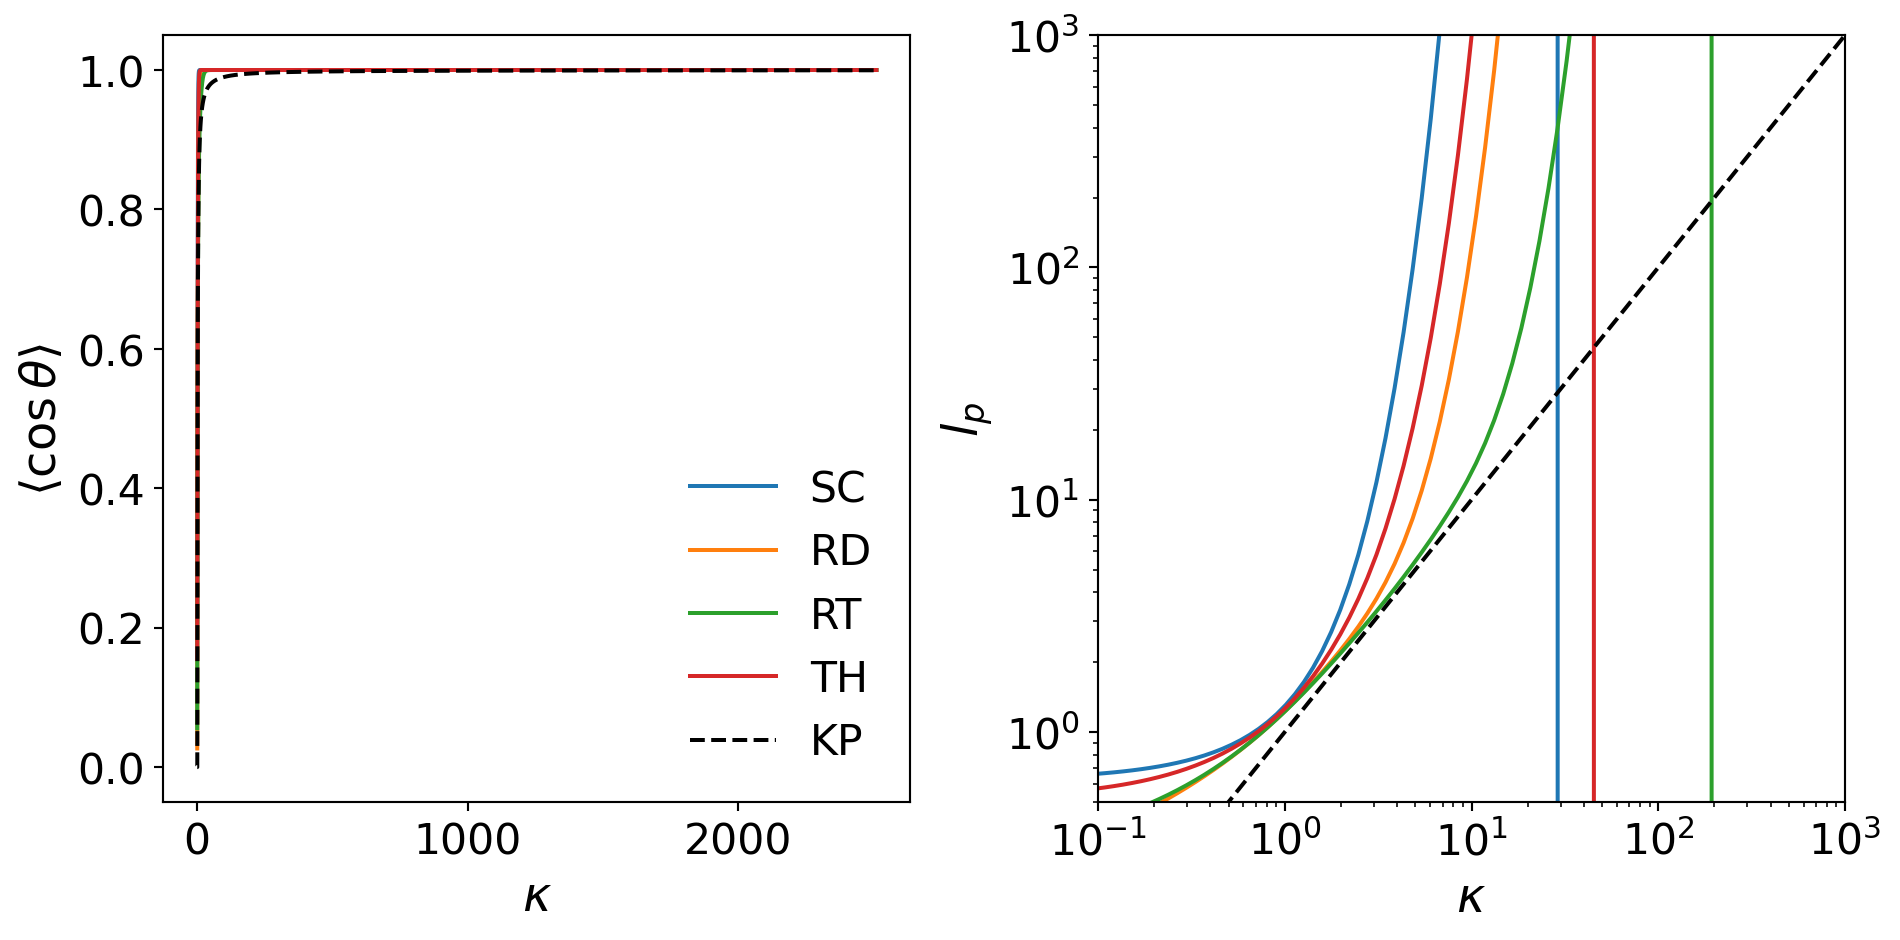

In [35]:
## provide lp/lb, evaluate the required kappa
# from f_chain import grid_coords
fig = plt.figure(figsize=(10, 5),dpi=192)

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
labels = ['SC','RD','RT','TH','OH']
for i, grid in enumerate(['SC','RB','RT','OHTH']):
    r_n, r_opp = grid_coords(grid)
    cos_i1 = r_n@r_n[0].T
    cos_i1[cos_i1>1]=1
    cos_i1[cos_i1<-1]=-1
    theta_i1 = np.arccos(cos_i1)

    def f_average(x, kappa):
        # x(theta) is a fumction of theta
        x_ave = np.sum(x*np.exp(-kappa/2*theta_i1**2))/np.sum(np.exp(-kappa/2*theta_i1**2))
        return x_ave

    def f_average_nonrev(x, kappa):
        # x(theta) is a fumction of theta
        x_ave = np.sum((x*np.exp(-kappa/2*theta_i1**2))[cos_i1>-1])/np.sum(np.exp(-kappa/2*theta_i1**2)[cos_i1>-1])
        return x_ave

    kappa_list = np.logspace(-1.4,3.4,100)
    cos_ave = np.array([f_average_nonrev(cos_i1, k) for k in kappa_list])
    lp_ave = -1/np.log(cos_ave)

    ax1.plot(kappa_list, cos_ave, label = labels[i])
    
    ax1.set_xlabel(r'$\kappa$',fontsize=18)
    ax1.set_ylabel(r'$\langle \cos\theta \rangle$',fontsize=18)
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ax2.plot(kappa_list, lp_ave, label = labels[i])
    
    ax2.set_xlabel(r'$\kappa$',fontsize=18)
    ax2.set_ylabel(r'$l_p$',fontsize=18)
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_ylim([0.5,1000])
    ax2.set_xlim([0.1,1000])
    ax2.tick_params(axis='both', which='major', labelsize=16)

ax1.plot(kappa_list, np.exp(-1/kappa_list), '--k', label = 'KP')
ax1.legend(fontsize=16, frameon=False)

ax2.plot(kappa_list, kappa_list, '--k', label = 'KP')
# ax2.legend(fontsize=16, frameon=False)

plt.tight_layout()

In [4]:
r_n, r_opp = grid_coords('OH')
cos_i1 = r_n@r_n[0].T
cos_i1
cos_i1[cos_i1>1]=1
cos_i1[cos_i1<-1]=-1
np.arccos(cos_i1)

array([0.        , 1.23095942, 1.23095942, 1.23095942, 1.91063324,
       1.91063324, 1.91063324, 3.14159265])

$l_p = \kappa$ for $l_p\approx 1$

In [5]:
from scipy import interpolate
def kappa_eff(l_p, grid, nonreverse=True):
    r_n, r_opp = grid_coords(grid)
    cos_i1 = r_n@r_n[0].T
    cos_i1[cos_i1>1]=1
    cos_i1[cos_i1<-1]=-1
    theta_i1 = np.arccos(cos_i1)

    def f_average(x, kappa):
        # x(theta) is a fumction of theta
        x_ave = np.sum(x*np.exp(-kappa/2*theta_i1**2))/np.sum(np.exp(-kappa/2*theta_i1**2))
        return x_ave

    def f_average_nonrev(x, kappa):
        # x(theta) is a fumction of theta
        x_ave = np.sum((x*np.exp(-kappa/2*theta_i1**2))[cos_i1>-1])/np.sum(np.exp(-kappa/2*theta_i1**2)[cos_i1>-1])
        return x_ave
    
    # get the relation between bending energy and chain persistence
    kappa_list = np.logspace(-2,2,200)
    if nonreverse:
        f_ave = f_average_nonrev
    else:
        f_ave = f_average

    cos_ave = np.array([f_ave(cos_i1, k) for k in kappa_list])
    sigma = 0
    lp_ave_list = -1/(np.log(cos_ave))

    # obtain the corresponding kappa_eff from interpolation
    i_finite = np.isfinite(lp_ave_list)
    # f_interp = interpolate.PchipInterpolator(lp_ave_list, kappa_list)
    # kap_eff = f_interp(l_p)
    kap_eff = np.interp(l_p, lp_ave_list[i_finite], kappa_list[i_finite])

    return kap_eff

    

[ 1  0  0  0  0 -1]


/tmp/ipykernel_2837570/4147206183.py:28: RuntimeWarning: divide by zero encountered in divide
  lp_ave = -1/np.log(cos_ave)


[ 1.00000000e+00 -1.00000000e+00 -2.23711432e-17  2.23711432e-17
  5.00000000e-01 -5.00000000e-01 -5.00000000e-01  5.00000000e-01
  5.00000000e-01 -5.00000000e-01 -5.00000000e-01  5.00000000e-01]
[ 1.          0.          0.         -1.          0.          0.
  0.30901699  0.80901699  0.5        -0.30901699 -0.80901699 -0.5
  0.30901699  0.80901699  0.5         0.30901699  0.80901699  0.5
 -0.30901699 -0.80901699 -0.5         0.30901699  0.80901699  0.5
 -0.30901699 -0.80901699 -0.5        -0.30901699 -0.80901699 -0.5       ]
[ 1.          0.33333333  0.33333333  0.33333333 -0.33333333 -0.33333333
 -0.33333333 -1.        ]


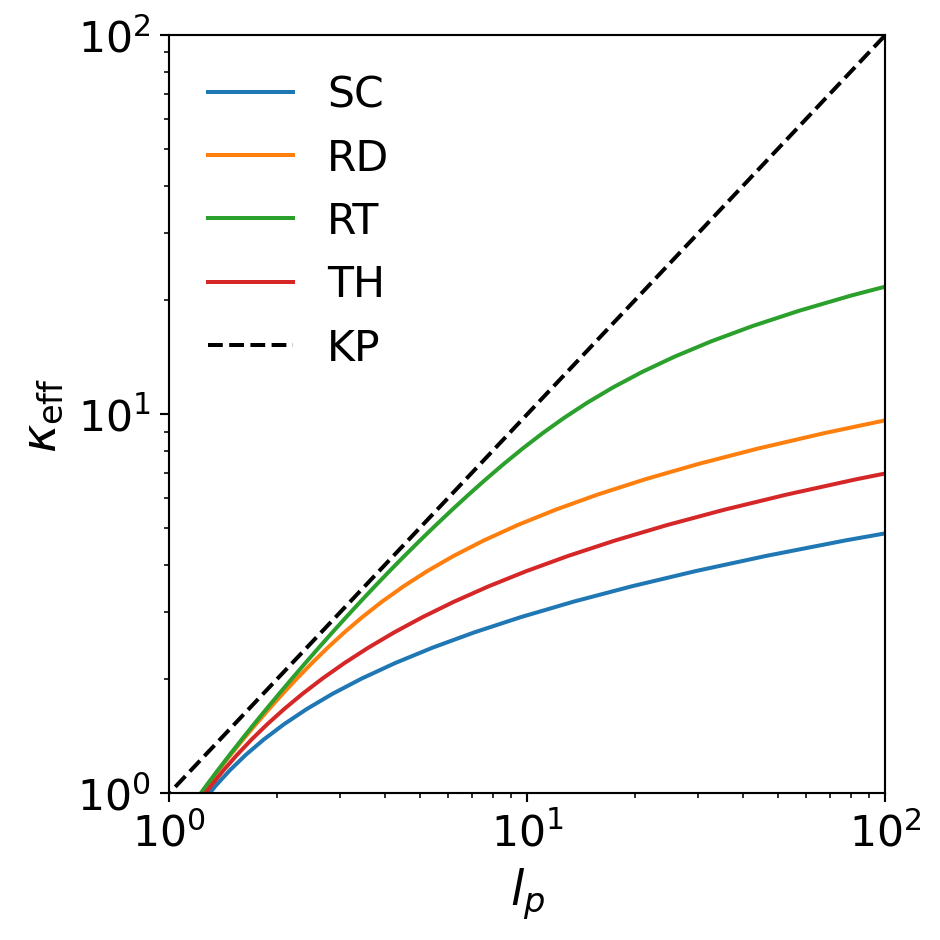

In [6]:
## provide lp/lb, evaluate the required kappa
# from f_chain import grid_coords
fig = plt.figure(figsize=(5, 5),dpi=192)

c_list = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
ax2 = fig.add_subplot(1,1,1)
labels = ['SC','RD','RT','TH','OH']
for i, grid in enumerate(['SC','RB','RT','OHTH']):
    r_n, r_opp = grid_coords(grid)
    cos_i1 = r_n@r_n[0].T
    cos_i1[cos_i1>1]=1
    cos_i1[cos_i1<-1]=-1
    theta_i1 = np.arccos(cos_i1)
    print(cos_i1)

    def f_average(x, kappa):
        # x(theta) is a fumction of theta
        x_ave = np.sum(x*np.exp(-kappa/2*theta_i1**2))/np.sum(np.exp(-kappa/2*theta_i1**2))
        return x_ave

    def f_average_nonrev(x, kappa):
        # x(theta) is a fumction of theta
        x_ave = np.sum((x*np.exp(-kappa/2*theta_i1**2))[cos_i1>-1])/np.sum(np.exp(-kappa/2*theta_i1**2)[cos_i1>-1])
        return x_ave

    kappa_list = np.logspace(-2,2,100)
    cos_ave = np.array([f_average_nonrev(cos_i1, k) for k in kappa_list])
    lp_ave = -1/np.log(cos_ave)
    i_finite = np.isfinite(lp_ave)

    l_p_list = np.logspace(-1,2,100)
    kappa_eff_list = [kappa_eff(l, grid, nonreverse=True) for l in l_p_list]

    ax2.plot(lp_ave[i_finite], kappa_list[i_finite], label = labels[i], color=c_list[i])
    # ax2.plot(l_p_list, kappa_eff_list, 'o', mfc='none', color=c_list[i])
    
    ax2.set_ylabel(r'$\kappa_{\rm{eff}}$',fontsize=18)
    ax2.set_xlabel(r'$l_p$',fontsize=18)
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_ylim([1,100])
    ax2.set_xlim([1,100])
    ax2.tick_params(axis='both', which='major', labelsize=16)

ax2.plot(kappa_list, kappa_list, '--k', label = 'KP')
ax2.legend(fontsize=16, frameon=False)

plt.tight_layout()

In [10]:
## Chain parameters
# Coordinate of C atoms in each unit
# unit_C = load('b_c.dat')';
unit_C = np.zeros((3,1))

# Degree of polymerization
N_backbone = 5000

# Chain stiffness (placeholder)
a_backbone = 1

# Unit persistence
lambda_backbone = 1

# Call WLChain class
chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
chain.apply_SA = 0
chain.d_exc = 0.1
chain.f = 0.0


In [36]:
kappa_list = np.array([5,50,500])
epsilon_list = [0]
parameters_list = []
for kappa in kappa_list:
    for epsilon in epsilon_list:
        parameters_list.append([kappa, epsilon])

In [37]:
def eval_corr(kappa, epsilon, chain, n_sample = 20, n_merge = 4, rayleigh=False):
    ## generate spectra of three different grids
    corr_list = []
    d = np.ceil(10**(np.arange(64)/8)).astype('int')
    d = d[d<chain.N]

    for i, grid in enumerate(['SC','RB','RT']):
        print(grid)
        corr = np.zeros(len(d))
        for j in range(n_sample):
            # chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
            chain.grid = grid
            chain.apply_SA = 0
            chain.d_exc = 0.1
            chain.f = 0.0
            chain.kappa = kappa
            chain.epsilon = epsilon

            chain.chain_grid()
            d, corr_j = chain.corr_o()

            corr = corr + corr_j
        corr = corr/n_sample
        corr_list.append(corr)

    if rayleigh:
        print('KP')
        corr = np.zeros(len(d))
        chain.a = kappa
        for j in range(n_sample):
            
            chain.apply_SA = 0
            chain.d_exc = 0.1
            chain.chain()
            d, corr_j = chain.corr_o()

            corr = corr + corr_j
        corr = corr/n_sample
        corr_list.append(corr)

    return np.array(corr_list)

In [38]:
corr_list_param = []
d = np.ceil(10**(np.arange(64)/8)).astype('int')
d = d[d<N_backbone]
for j, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    print(params)

    corr_list_grid = eval_corr(kappa, epsilon, chain, n_sample = 64, n_merge = 1, rayleigh=True)
    corr_list_param.append(corr_list_grid)

[5, 0]
SC
RB
RT
KP
[50, 0]
SC
RB
RT
KP
[500, 0]
SC
RB
RT
KP


[5, 0]
[50, 0]
[500, 0]


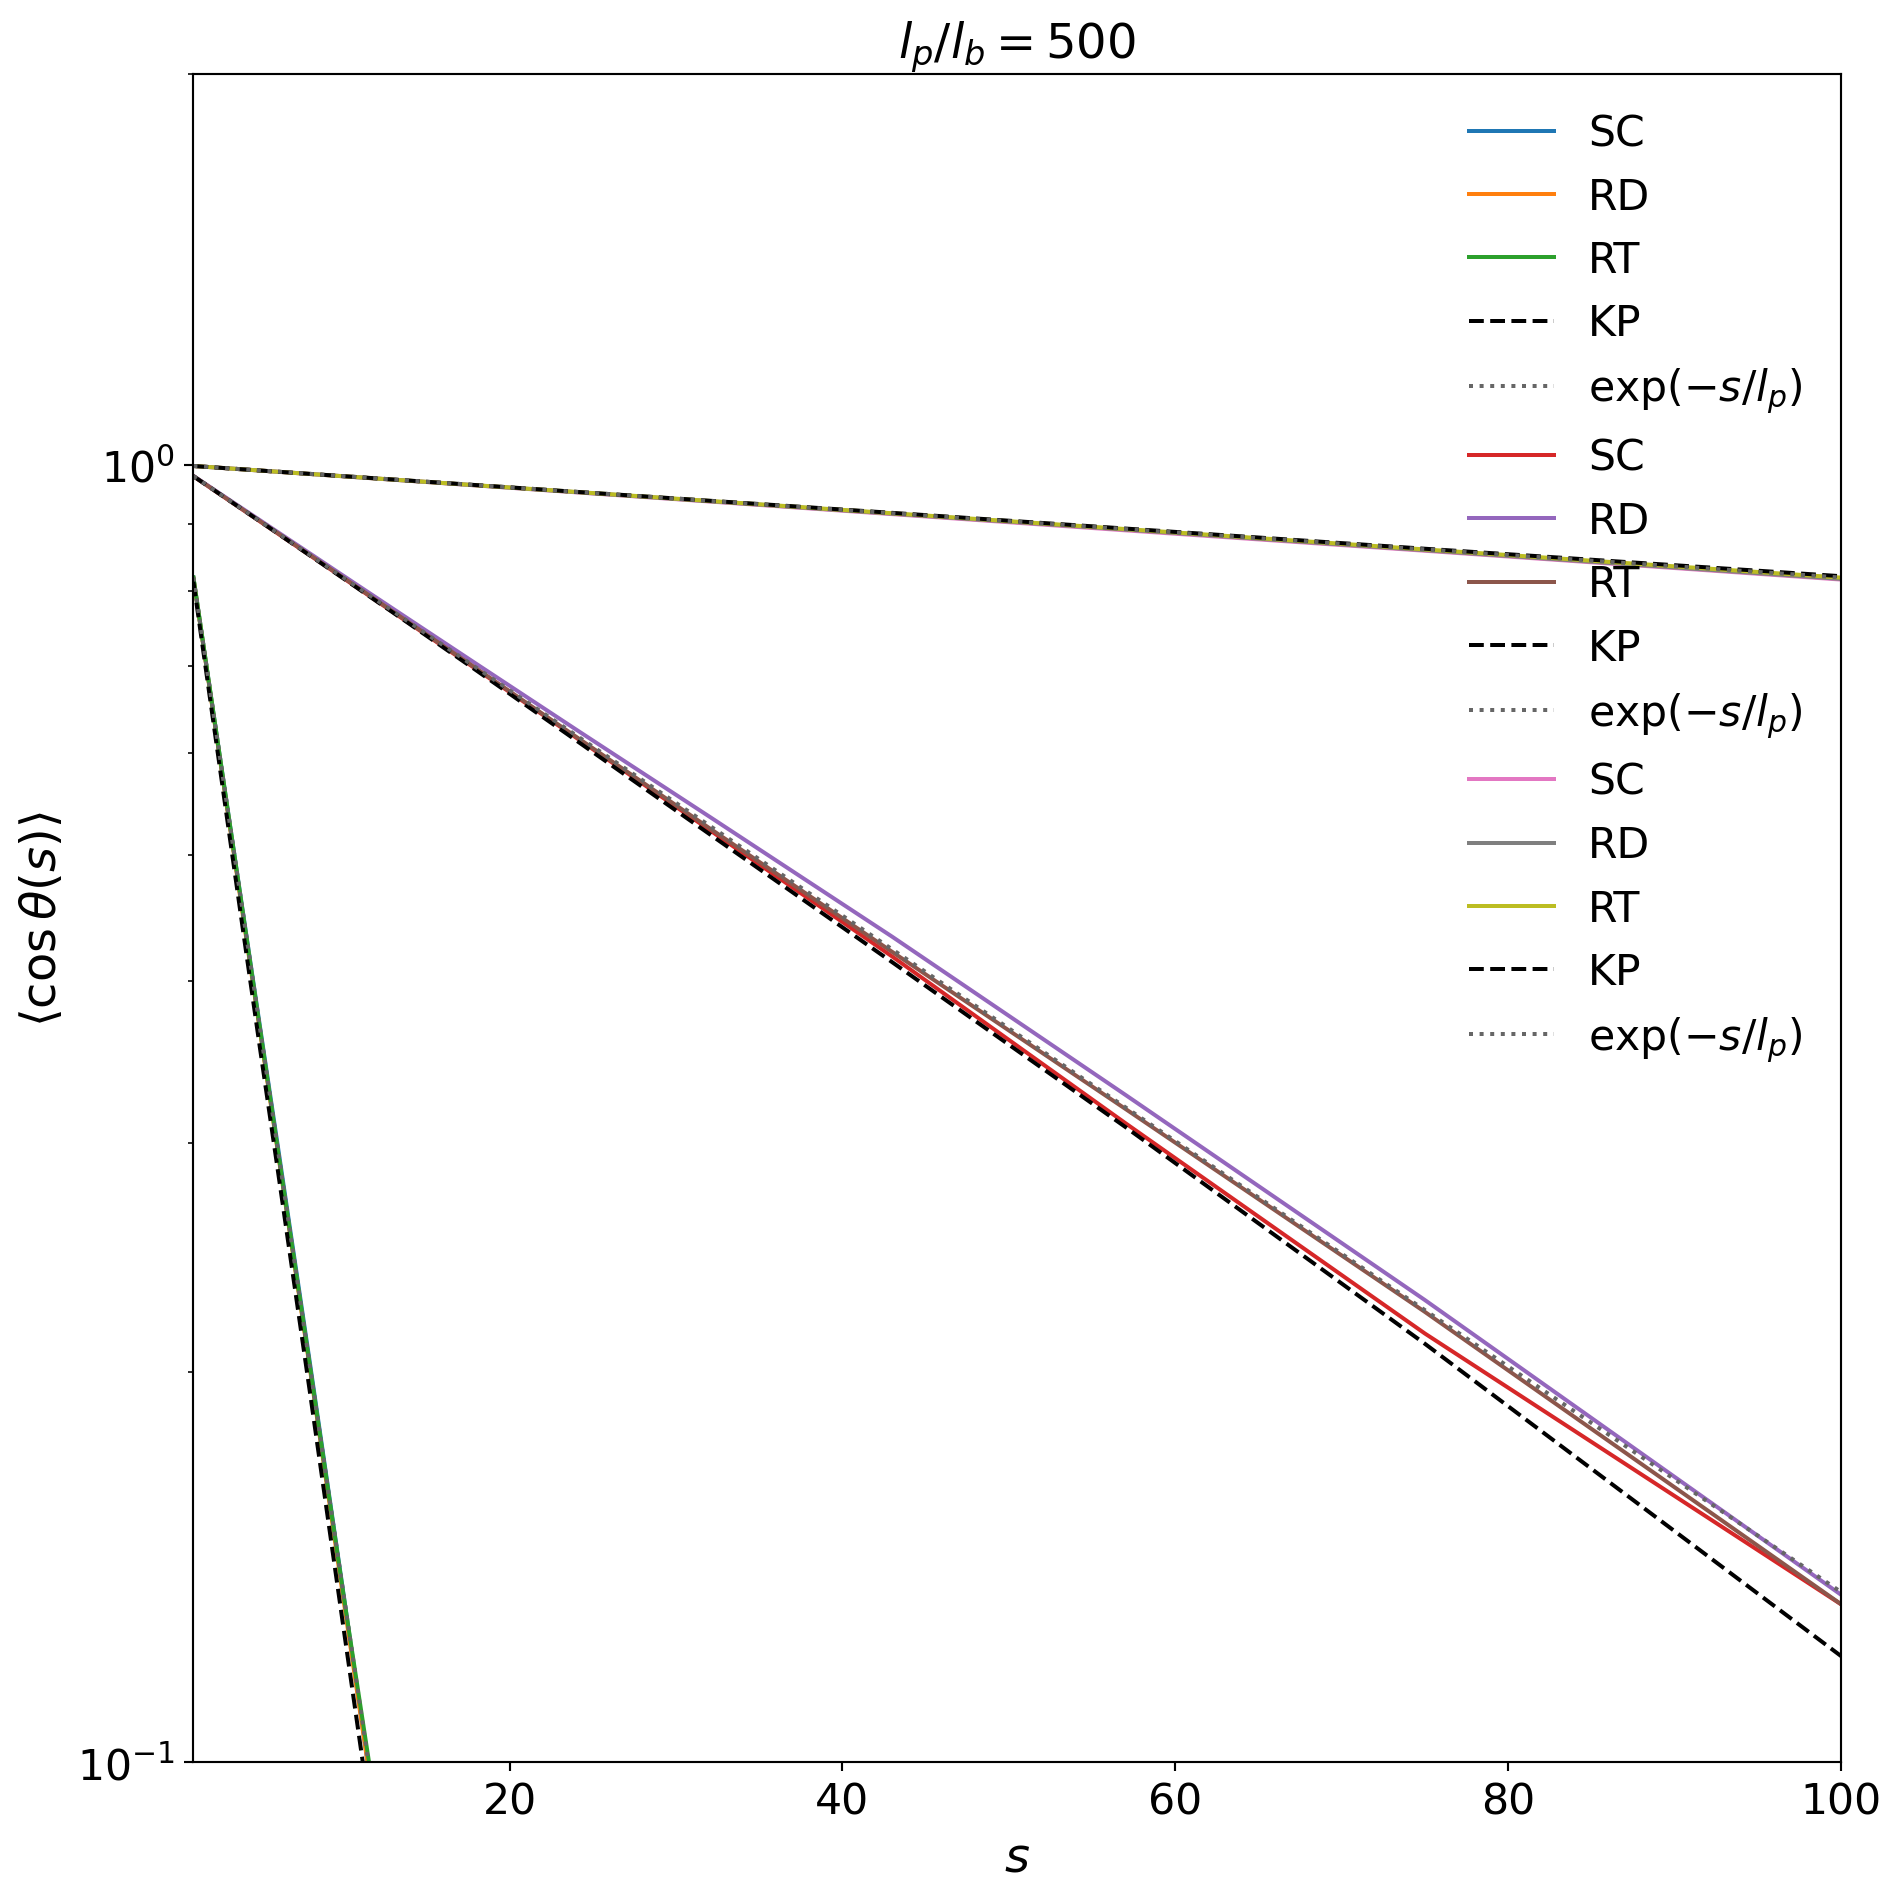

In [39]:
fig = plt.figure(figsize=(10, 10),dpi=192)
ax = fig.add_subplot(1,1,1)
for j, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    print(params)
    
    
    ax.set_title(r'$l_p/l_b = {}$'.format(kappa),fontsize=18)
    for i, grid in enumerate(['SC','RD','RT']):
        ax.plot(d,corr_list_param[j][i], label=grid)
    ax.plot(d,corr_list_param[j][3], '--', label='KP', color='k')
    ax.plot(d, np.exp(-d/kappa), ':', color='#666666', label=r'$\exp(-s/l_p)$')
    
    # ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(fontsize=16, frameon=False)
    ax.set_xlim([1,100])
    ax.set_ylim([1e-1,2])
    ax.set_xlabel(r'$s$',fontsize=18)
    ax.set_ylabel(r'$\langle \cos\theta(s) \rangle$',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()


/tmp/ipykernel_2837570/3915588078.py:27: RuntimeWarning: divide by zero encountered in divide
  lp_ave = -1/np.log(cos_ave)


[50, 0]


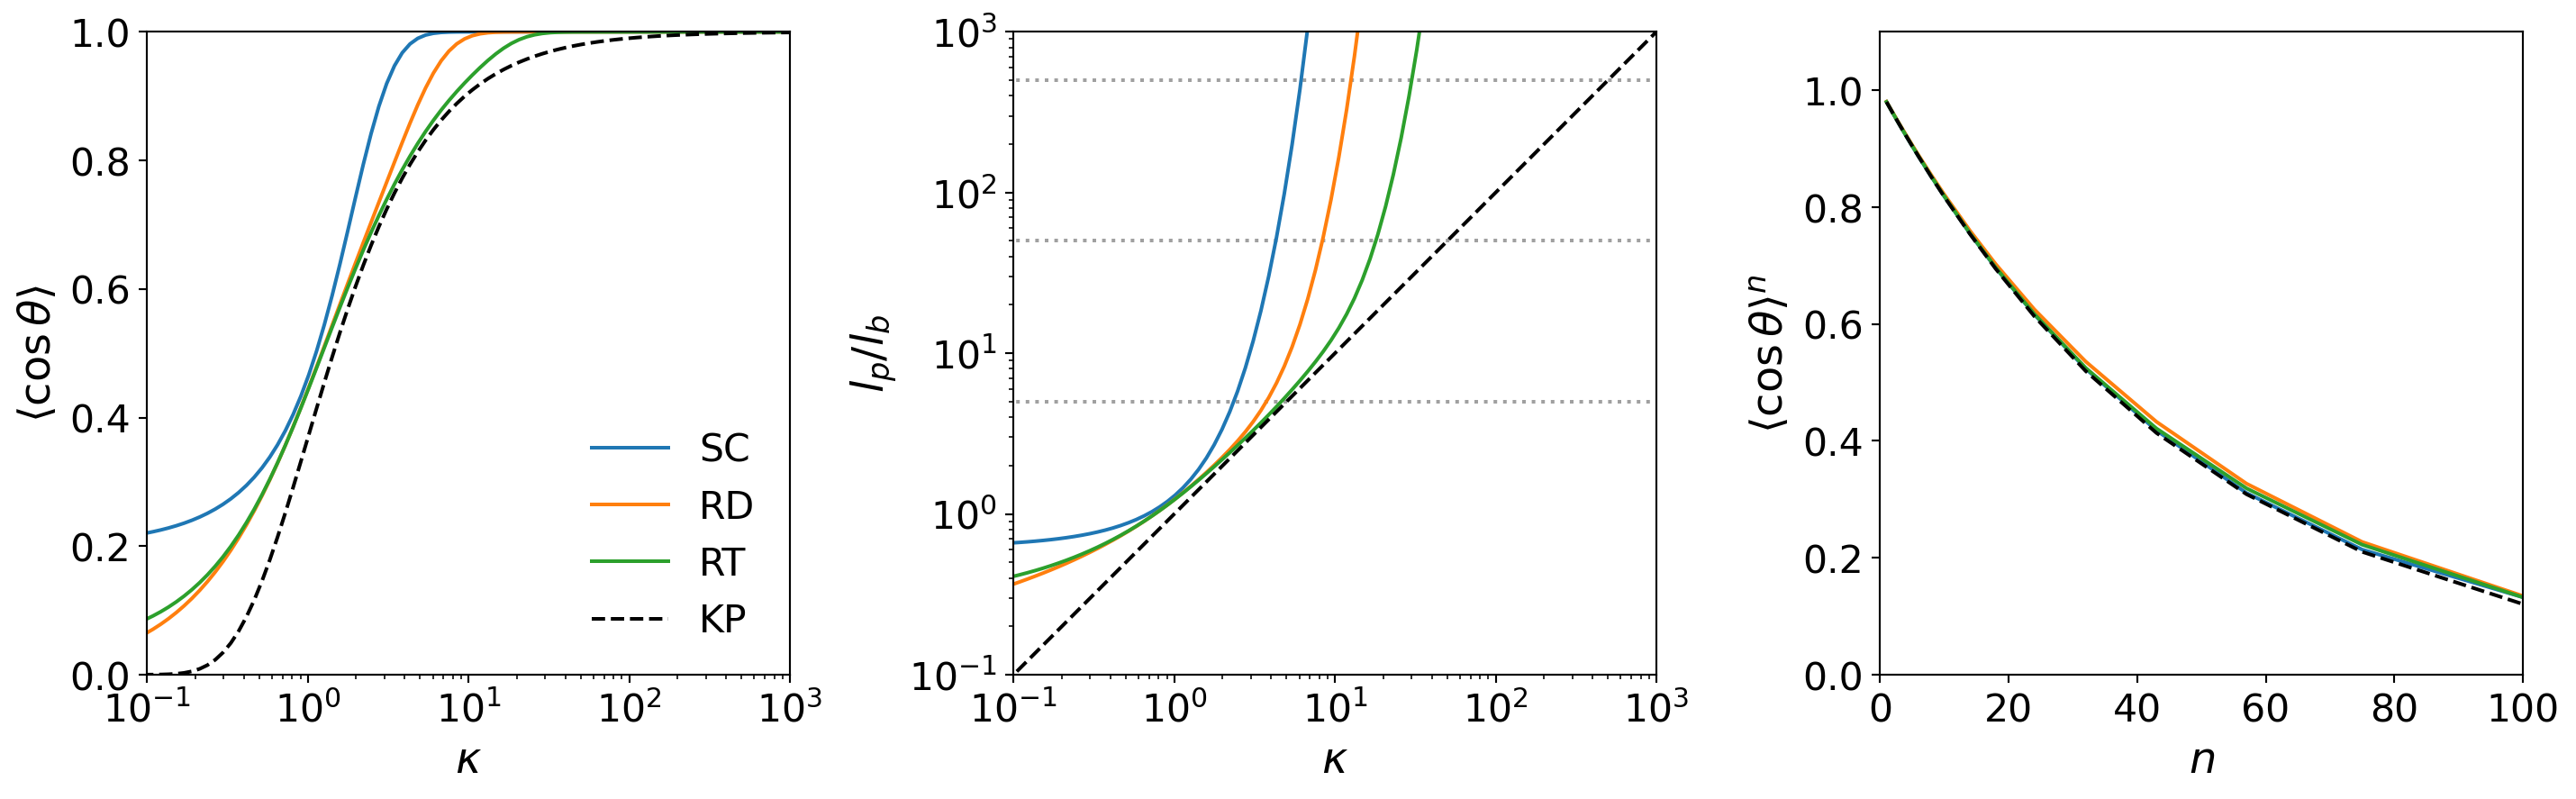

In [67]:
## provide lp/lb, evaluate the required kappa
# from f_chain import grid_coords
fig = plt.figure(figsize=(15, 5),dpi=192)

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
labels = ['SC','RD','RT','TH','OH']
for i, grid in enumerate(['SC','RB','RT']):
    r_n, r_opp = grid_coords(grid)
    cos_i1 = r_n@r_n[0].T
    cos_i1[cos_i1>1]=1
    cos_i1[cos_i1<-1]=-1
    theta_i1 = np.arccos(cos_i1)

    def f_average(x, kappa):
        # x(theta) is a fumction of theta
        x_ave = np.sum(x*np.exp(-kappa/2*theta_i1**2))/np.sum(np.exp(-kappa/2*theta_i1**2))
        return x_ave

    def f_average_nonrev(x, kappa):
        # x(theta) is a fumction of theta
        x_ave = np.sum((x*np.exp(-kappa/2*theta_i1**2))[cos_i1>-1])/np.sum(np.exp(-kappa/2*theta_i1**2)[cos_i1>-1])
        return x_ave

    kappa_list = np.logspace(-1.4,3.4,100)
    cos_ave = np.array([f_average_nonrev(cos_i1, k) for k in kappa_list])
    lp_ave = -1/np.log(cos_ave)
    lp_ave[np.isfinite(lp_ave)==False] = np.NaN

    ax1.plot(kappa_list, cos_ave, label = labels[i])
    ax2.plot(kappa_list, lp_ave, label = labels[i])

ax1.set_ylim([0,1])
ax1.set_xlim([0.1,1000]) 
ax1.set_xscale('log')  
ax1.set_xlabel(r'$\kappa$',fontsize=18)
ax1.set_ylabel(r'$\langle \cos\theta \rangle$',fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_aspect(4)

ax2.set_xlabel(r'$\kappa$',fontsize=18)
ax2.set_ylabel(r'$l_p/l_b$',fontsize=18)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim([0.1,1000])
ax2.set_xlim([0.1,1000])
ax2.tick_params(axis='both', which='major', labelsize=16)

ax2.plot(kappa_list, 5*np.ones_like(kappa_list), ':', color="#A0A0A0", zorder=-1)
ax2.plot(kappa_list, 50*np.ones_like(kappa_list), ':', color="#A0A0A0", zorder=-1)
ax2.plot(kappa_list, 500*np.ones_like(kappa_list), ':', color="#A0A0A0", zorder=-1)
ax2.set_aspect(1)

ax1.plot(kappa_list, np.exp(-1/kappa_list), '--k', label = 'KP')
ax1.legend(fontsize=16, frameon=False, loc="lower right")

ax2.plot(kappa_list, kappa_list, '--k', label = 'KP')
# ax2.legend(fontsize=16, frameon=False)

ax3 = fig.add_subplot(1,3,3)
ax3.set_aspect(100/1.1)
for j, params in enumerate([parameters_list[1]]):
    kappa = params[0]
    epsilon = params[1]
    print(params)
    
    
    # ax3.set_title(r'$l_p/l_b = {}$'.format(kappa),fontsize=18)
    for i, grid in enumerate(['SC','RD','RT']):
        ax3.plot(d,corr_list_param[1][i], label=grid)
    ax3.plot(d,corr_list_param[1][3], '--', label='KP', color='k')
    ax.plot(d, np.exp(-d/kappa), ':', color='#666666', label=r'$\exp(-s/l_p)$')
    
    # ax.set_xscale('log')
    # ax3.set_yscale('log')
    # ax3.legend(fontsize=16, frameon=False)
    ax3.set_xlim([0,100])
    ax3.set_ylim([0,1.1])
    ax3.set_xlabel(r'$n$',fontsize=18)
    ax3.set_ylabel(r'$\langle \cos\theta \rangle^n$',fontsize=18)
    ax3.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()

plt.tight_layout()